# Modelo de predicción de precios de viviendas
Se creo un modelo de ML para predecir precios de casas. Ayuda en decisiones de inversión inmobiliaria con precisión. Utiliza aprendizaje supervisado, error cuadrático medio y una API para su accesibilidad.

Descargo los datos de un repositorio público. El dataset es abierto para uso libre.

In [19]:
import requests
import tarfile

URL = "https://mymldatasets.s3.eu-de.cloud-object-storage.appdomain.cloud/housing.tgz"
PATH = "housing.tgz"

def getData(url=URL, path=PATH):
  r = requests.get(url)
  with open(path, 'wb') as f:
    f.write(r.content)
  housing_tgz = tarfile.open(path)
  housing_tgz.extractall()
  housing_tgz.close()

In [20]:
getData()

In [21]:
import pandas as pd

PATH = "housing.csv"

def loadData(path=PATH):
  return pd.read_csv(path)

In [22]:
data = loadData()
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20640 entries, 0 to 20639
Data columns (total 10 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   longitude           20640 non-null  float64
 1   latitude            20640 non-null  float64
 2   housing_median_age  20640 non-null  float64
 3   total_rooms         20640 non-null  float64
 4   total_bedrooms      20433 non-null  float64
 5   population          20640 non-null  float64
 6   households          20640 non-null  float64
 7   median_income       20640 non-null  float64
 8   median_house_value  20640 non-null  float64
 9   ocean_proximity     20640 non-null  object 
dtypes: float64(9), object(1)
memory usage: 1.6+ MB


El dataset ocupa unos 1.6MB de memoria, por lo que puedo almacenarlo sin problemas de forma local. Además, contiene información de tipo geográfico (latitud y longitud) con 8 características de tipo numérico y 1 de tipo categórico.

In [23]:
data.sample(5)

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value,ocean_proximity
7001,-118.05,33.96,37.0,2622.0,652.0,2778.0,644.0,2.9714,160300.0,<1H OCEAN
9953,-122.36,38.41,18.0,1808.0,400.0,968.0,370.0,3.7067,175000.0,INLAND
19500,-121.03,37.67,24.0,2162.0,459.0,1468.0,441.0,3.1857,98300.0,INLAND
15622,-122.41,37.80,52.0,2618.0,611.0,1328.0,559.0,4.1607,350000.0,NEAR BAY
11657,-118.02,33.83,26.0,3616.0,892.0,2257.0,821.0,3.1497,217600.0,<1H OCEAN


Genero una muestra de test que sólo usaré al final de todo para evaluar el modelo.

In [24]:
from sklearn.model_selection import train_test_split

train, test = train_test_split(data, test_size=0.2, random_state=22)

train.to_csv('housing_train.csv', index=False)
test.to_csv('housing_test.csv', index=False)

# Voy a explorar y visualizar los datos

In [25]:
%matplotlib inline
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl

mpl.rc('axes', labelsize=14)
mpl.rc('xtick', labelsize=12)
mpl.rc('ytick', labelsize=12)

In [26]:
data.describe()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value
count,20640.000000,20640.000000,20640.000000,20640.000000,20433.000000,20640.000000,20640.000000,20640.000000,20640.000000
mean,-119.569704,35.631861,28.639486,2635.763081,537.870553,1425.476744,499.539680,3.870671,206855.816909
std,2.003532,2.135952,12.585558,2181.615252,421.385070,1132.462122,382.329753,1.899822,115395.615874
min,-124.350000,32.540000,1.000000,2.000000,1.000000,3.000000,1.000000,0.499900,14999.000000
25%,-121.800000,33.930000,18.000000,1447.750000,296.000000,787.000000,280.000000,2.563400,119600.000000
50%,-118.490000,34.260000,29.000000,2127.000000,435.000000,1166.000000,409.000000,3.534800,179700.000000
75%,-118.010000,37.710000,37.000000,3148.000000,647.000000,1725.000000,605.000000,4.743250,264725.000000
max,-114.310000,41.950000,52.000000,39320.000000,6445.000000,35682.000000,6082.000000,15.000100,500001.000000


In [27]:
data['ocean_proximity'].value_counts()

ocean_proximity
<1H OCEAN     9136
INLAND        6551
NEAR OCEAN    2658
NEAR BAY      2290
ISLAND           5
Name: count, dtype: int64

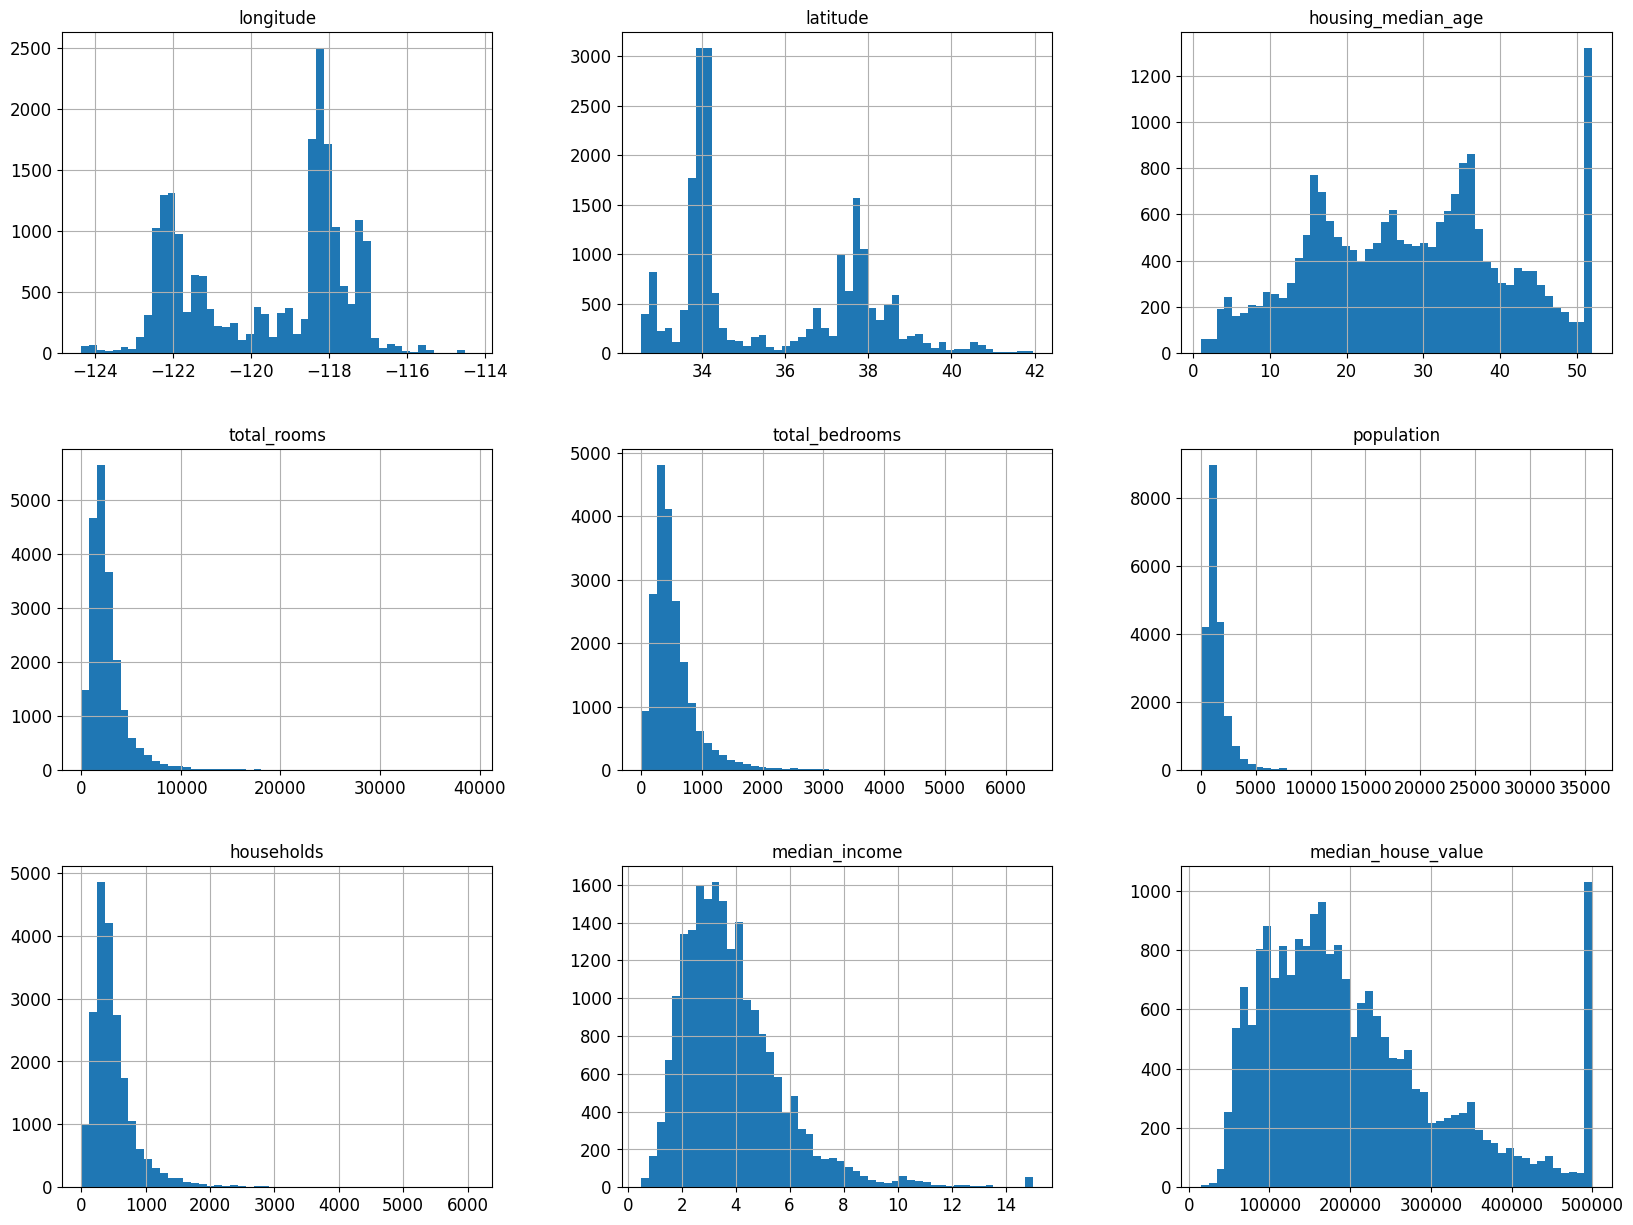

In [28]:
data.hist(bins=50, figsize=(20,15))
plt.show()

El siguiente gráfico muestra una visualización muy práctica y conveniente para el problema que afrontamos en particular. Se observan todos los atributos del dataset usando la información geográfica en los ejes x e y como puntos, cuyo tamaño indica la población y el color representa el valor medio de una casa.(El valor objetivo)

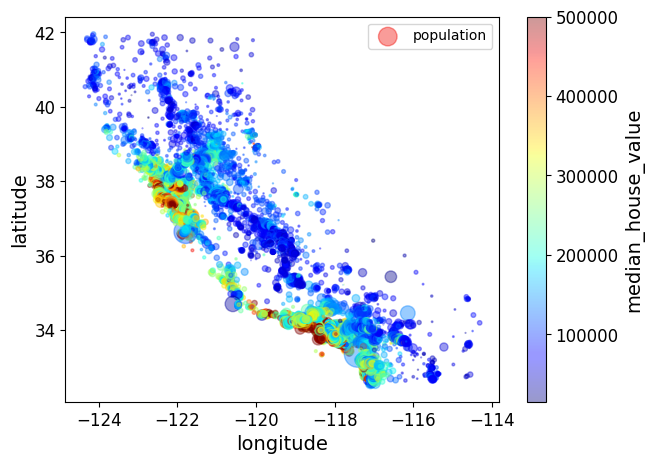

In [29]:
data.plot(kind="scatter", x="longitude", y="latitude", alpha=0.4,
    s=data["population"]/100, label="population", figsize=(7,5),
    c="median_house_value", cmap=plt.get_cmap("jet"), colorbar=True,
    sharex=False)
plt.legend()
plt.show()

Se busca correlaciones entre los diferentes atributos.

In [30]:
data_without_column = data.drop(['ocean_proximity'], axis=1).copy()

corr_matrix = data_without_column.corr()

# Ordeno las correlaciones con respecto a 'median_house_value'
corr_sorted = corr_matrix['median_house_value'].sort_values(ascending=False)
print(corr_sorted)


median_house_value    1.000000
median_income         0.688075
total_rooms           0.134153
housing_median_age    0.105623
households            0.065843
total_bedrooms        0.049686
population           -0.024650
longitude            -0.045967
latitude             -0.144160
Name: median_house_value, dtype: float64


Se puede ver, que la variable más correlacionada con el valor de una casa es el ingreso medio de la población, mientras que aspectos como el número de habitaciones o la población de la zona no son tan importantes.

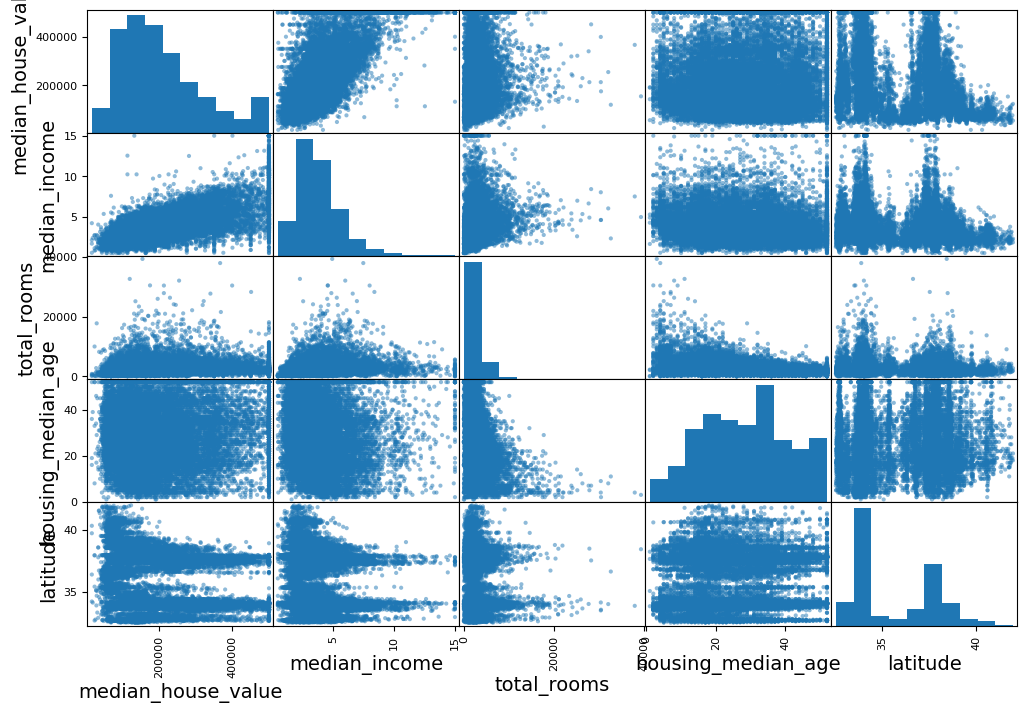

In [31]:
from pandas.plotting import scatter_matrix

attributes = ["median_house_value", "median_income", "total_rooms","housing_median_age", "latitude"]
scatter_matrix(data[attributes], figsize=(12, 8))
plt.show()

# Preparo los datos

In [32]:
data = pd.read_csv('housing_train.csv')
data, labels = data.drop(['median_house_value'], axis=1), data['median_house_value'].copy()
data.head()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,ocean_proximity
0,-119.72,36.76,23.0,6403.0,NaN,3573.0,1260.0,2.3006,INLAND
1,-120.79,38.70,13.0,5036.0,1034.0,2243.0,923.0,2.3319,INLAND
2,-118.20,34.04,18.0,796.0,227.0,547.0,218.0,1.0333,<1H OCEAN
3,-117.34,33.21,12.0,5963.0,1372.0,3015.0,1124.0,2.7386,NEAR OCEAN
4,-121.46,38.54,48.0,1001.0,205.0,605.0,175.0,1.8333,INLAND


In [33]:
labels.head()

0     69000.0
1    138500.0
2    135400.0
3    216100.0
4     58200.0
Name: median_house_value, dtype: float64

Las variables numéricas y categóricas se tratan de manera diferente, por ende  las voy a separar.

In [34]:
data_num = data.drop(['ocean_proximity'], axis=1)
data_num.head()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income
0,-119.72,36.76,23.0,6403.0,NaN,3573.0,1260.0,2.3006
1,-120.79,38.70,13.0,5036.0,1034.0,2243.0,923.0,2.3319
2,-118.20,34.04,18.0,796.0,227.0,547.0,218.0,1.0333
3,-117.34,33.21,12.0,5963.0,1372.0,3015.0,1124.0,2.7386
4,-121.46,38.54,48.0,1001.0,205.0,605.0,175.0,1.8333


In [35]:
data_cat = data[['ocean_proximity']]
data_cat.head()

,ocean_proximity
0,INLAND
1,INLAND
2,<1H OCEAN
3,NEAR OCEAN
4,INLAND


In [36]:
data_num.isnull().sum()

longitude               0
latitude                0
housing_median_age      0
total_rooms             0
total_bedrooms        163
population              0
households              0
median_income           0
dtype: int64

Trato los *missing values*.

In [37]:
from sklearn.impute import SimpleImputer

imputer = SimpleImputer(strategy="median")
imputer.fit(data_num)
imputer.statistics_

C:\Users\Lic.Balzarelli\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:767: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if not hasattr(array, "sparse") and array.dtypes.apply(is_sparse).any():
C:\Users\Lic.Balzarelli\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:605: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype):
C:\Users\Lic.Balzarelli\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:614: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinsta

array([-118.51  ,   34.26  ,   29.    , 2126.    ,  435.    , 1165.    ,
        410.    ,    3.5334])

In [38]:
X = imputer.transform(data_num)
data_tr = pd.DataFrame(X, columns=data_num.columns, index=data.index)
data_tr.isnull().sum()

C:\Users\Lic.Balzarelli\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:767: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if not hasattr(array, "sparse") and array.dtypes.apply(is_sparse).any():
C:\Users\Lic.Balzarelli\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:605: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype):
C:\Users\Lic.Balzarelli\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:614: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinsta

longitude             0
latitude              0
housing_median_age    0
total_rooms           0
total_bedrooms        0
population            0
households            0
median_income         0
dtype: int64

Trato los datos categóricos. Hago un one-hot encoding.

In [39]:
from sklearn.preprocessing import OneHotEncoder

cat_encoder = OneHotEncoder()
data_cat_1hot = cat_encoder.fit_transform(data_cat)
data_cat_1hot.toarray()

C:\Users\Lic.Balzarelli\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:605: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype):


C:\Users\Lic.Balzarelli\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:614: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype) or not is_extension_array_dtype(pd_dtype):
C:\Users\Lic.Balzarelli\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:605: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype):
C:\Users\Lic.Balzarelli\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:614: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dty

array([[0., 1., 0., 0., 0.],
       [0., 1., 0., 0., 0.],
       [1., 0., 0., 0., 0.],
       ...,
       [0., 0., 0., 1., 0.],
       [0., 0., 0., 0., 1.],
       [1., 0., 0., 0., 0.]])

Añado características

In [40]:
from sklearn.base import BaseEstimator, TransformerMixin

# column index
rooms_ix, bedrooms_ix, population_ix, households_ix = 3, 4, 5, 6

class CombinedAttributesAdder(BaseEstimator, TransformerMixin):
    def __init__(self, add_bedrooms_per_room = True): # no *args or **kargs
        self.add_bedrooms_per_room = add_bedrooms_per_room

    def fit(self, X, y=None):
        return self  # nothing else to do

    def transform(self, X):
        rooms_per_household = X[:, rooms_ix] / X[:, households_ix]
        population_per_household = X[:, population_ix] / X[:, households_ix]
        if self.add_bedrooms_per_room:
            bedrooms_per_room = X[:, bedrooms_ix] / X[:, rooms_ix]
            return np.c_[X, rooms_per_household, population_per_household, bedrooms_per_room]
        else:
            return np.c_[X, rooms_per_household, population_per_household]

In [41]:
attr_adder = CombinedAttributesAdder(add_bedrooms_per_room=False)
data_extra_attribs = attr_adder.transform(data.values)
data_extra_attribs.shape # 9 + 2

(16512, 11)

Normalizo los datos numéricos

In [42]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
data_scaled = scaler.fit_transform(data_num)
data_tr = pd.DataFrame(data_scaled, columns=data_num.columns, index=data.index)
data_tr.describe()

C:\Users\Lic.Balzarelli\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:767: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if not hasattr(array, "sparse") and array.dtypes.apply(is_sparse).any():
C:\Users\Lic.Balzarelli\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:605: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype):
C:\Users\Lic.Balzarelli\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:614: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinsta

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income
count,1.651200e+04,1.651200e+04,1.651200e+04,1.651200e+04,1.634900e+04,1.651200e+04,1.651200e+04,1.651200e+04
mean,7.217525e-16,6.491362e-16,1.207583e-16,2.216143e-17,-2.933613e-18,7.627404e-17,4.028862e-17,-6.981926e-17
std,1.000030e+00,1.000030e+00,1.000030e+00,1.000030e+00,1.000031e+00,1.000030e+00,1.000030e+00,1.000030e+00
min,-2.381604e+00,-1.445235e+00,-2.201136e+00,-1.214416e+00,-1.278351e+00,-1.256377e+00,-1.310671e+00,-1.764526e+00
25%,-1.105456e+00,-7.998537e-01,-8.491991e-01,-5.457575e-01,-5.776820e-01,-5.636872e-01,-5.758077e-01,-6.848289e-01
50%,5.324548e-01,-6.455233e-01,2.558386e-02,-2.329159e-01,-2.440301e-01,-2.270859e-01,-2.333984e-01,-1.765975e-01
75%,7.819462e-01,9.679302e-01,6.617896e-01,2.338048e-01,2.564478e-01,2.609859e-01,2.723138e-01,4.571083e-01
max,2.628182e+00,2.950841e+00,1.854675e+00,1.631534e+01,1.407917e+01,3.034782e+01,1.470618e+01,5.825810e+00


Junto todo en una Pipeline que sea capaz de aceptar los datos tal y como vienen de leer el csv y los deje listos para ser usados por el modelo (aplicando todas las transformaciones anteriores).

In [43]:
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer

num_attribs = list(data_num)
cat_attribs = ["ocean_proximity"]

num_pipeline = Pipeline([
        ('imputer', SimpleImputer(strategy="median")),
        ('attribs_adder', CombinedAttributesAdder()),
        ('std_scaler', StandardScaler()),
    ])

full_pipeline = ColumnTransformer([
        ("num", num_pipeline, num_attribs),
        ("cat", OneHotEncoder(), cat_attribs),
    ])

data_prepared = full_pipeline.fit_transform(data)
data_prepared.shape # 8 numericas + 3 adicionales + 5 categoricas one hot encoded

C:\Users\Lic.Balzarelli\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:767: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if not hasattr(array, "sparse") and array.dtypes.apply(is_sparse).any():
C:\Users\Lic.Balzarelli\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:605: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype):
C:\Users\Lic.Balzarelli\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:614: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinsta

(16512, 16)

# Selecciono y Entreno un Modelo

In [44]:
from sklearn.linear_model import LinearRegression

lin_reg = LinearRegression()
lin_reg.fit(data_prepared, labels)

C:\Users\Lic.Balzarelli\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:605: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype):
C:\Users\Lic.Balzarelli\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:614: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype) or not is_extension_array_dtype(pd_dtype):


LinearRegression()

In [45]:
from sklearn.model_selection import cross_val_score

scores = cross_val_score(lin_reg, data_prepared, labels, scoring="neg_mean_squared_error", cv=10)
lin_rmse_scores = np.sqrt(-scores)

C:\Users\Lic.Balzarelli\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:605: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype):
C:\Users\Lic.Balzarelli\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:614: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype) or not is_extension_array_dtype(pd_dtype):
C:\Users\Lic.Balzarelli\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:605: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dty

In [46]:
def display_scores(scores):
    print("Scores:", scores)
    print("Mean:", scores.mean())
    print("Standard deviation:", scores.std())

display_scores(lin_rmse_scores)

Scores: [66437.86587554 67017.05947527 68432.15315087 72976.84720006
 71744.30539608 68479.63555331 69612.83771288 69513.25260389
 70670.12226447 66708.70099048]
Mean: 69159.27802228527
Standard deviation: 2070.2898903422656


In [47]:
from sklearn.tree import DecisionTreeRegressor

tree_reg = DecisionTreeRegressor(random_state=42)
tree_reg.fit(data_prepared, labels)

C:\Users\Lic.Balzarelli\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:605: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype):
C:\Users\Lic.Balzarelli\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:614: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype) or not is_extension_array_dtype(pd_dtype):


DecisionTreeRegressor(random_state=42)

In [48]:
scores = cross_val_score(tree_reg, data_prepared, labels, scoring="neg_mean_squared_error", cv=10)
tree_rmse_scores = np.sqrt(-scores)
display_scores(tree_rmse_scores)

C:\Users\Lic.Balzarelli\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:605: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype):
C:\Users\Lic.Balzarelli\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:614: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype) or not is_extension_array_dtype(pd_dtype):


C:\Users\Lic.Balzarelli\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:605: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype):
C:\Users\Lic.Balzarelli\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:614: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype) or not is_extension_array_dtype(pd_dtype):
C:\Users\Lic.Balzarelli\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:605: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dty

Scores: [68703.4303478  72987.81742712 71233.51615824 70066.66438864
 72373.81760126 68460.05433753 70375.70934853 70646.82923159
 72878.96434678 72629.31645032]
Mean: 71035.61196378153
Standard deviation: 1586.7249169822012


C:\Users\Lic.Balzarelli\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:605: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype):
C:\Users\Lic.Balzarelli\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:614: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype) or not is_extension_array_dtype(pd_dtype):


In [49]:
from sklearn.ensemble import RandomForestRegressor

forest_reg = RandomForestRegressor(random_state=42)
forest_reg.fit(data_prepared, labels)
forest_scores = cross_val_score(forest_reg, data_prepared, labels, scoring="neg_mean_squared_error", cv=10)
forest_rmse_scores = np.sqrt(-forest_scores)
display_scores(forest_rmse_scores)

C:\Users\Lic.Balzarelli\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:605: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype):
C:\Users\Lic.Balzarelli\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:614: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype) or not is_extension_array_dtype(pd_dtype):
C:\Users\Lic.Balzarelli\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:605: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dty

Scores: [45637.58713947 49631.22910104 50519.55905349 50609.95649911
 51309.02977016 50889.62631257 51532.353351   52301.92975819
 51709.06028876 48820.41504381]
Mean: 50296.074631759584
Standard deviation: 1827.4658318410761


C:\Users\Lic.Balzarelli\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:605: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype):
C:\Users\Lic.Balzarelli\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:614: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype) or not is_extension_array_dtype(pd_dtype):


# Ajusto el modelo
Optimización de hyperparámetros

In [50]:
from sklearn.model_selection import GridSearchCV

param_grid = [
    # try 12 (3×4) combinations of hyperparameters
    {'n_estimators': [3, 10, 30], 'max_features': [2, 4, 6, 8]},
    # then try 6 (2×3) combinations with bootstrap set as False
    {'bootstrap': [False], 'n_estimators': [3, 10], 'max_features': [2, 3, 4]},
  ]

forest_reg = RandomForestRegressor(random_state=42)
grid_search = GridSearchCV(forest_reg, param_grid, cv=5, scoring='neg_mean_squared_error', return_train_score=True, n_jobs=-1)
grid_search.fit(data_prepared, labels)

C:\Users\Lic.Balzarelli\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:605: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype):
C:\Users\Lic.Balzarelli\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:614: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype) or not is_extension_array_dtype(pd_dtype):


GridSearchCV(cv=5, estimator=RandomForestRegressor(random_state=42), n_jobs=-1,
             param_grid=[{'max_features': [2, 4, 6, 8],
                          'n_estimators': [3, 10, 30]},
                         {'bootstrap': [False], 'max_features': [2, 3, 4],
                          'n_estimators': [3, 10]}],
             return_train_score=True, scoring='neg_mean_squared_error')

In [51]:
GridSearchCV(cv=5, estimator=RandomForestRegressor(random_state=42), n_jobs=-1,
             param_grid=[{'max_features': [2, 4, 6, 8],
                          'n_estimators': [3, 10, 30]},
                         {'bootstrap': [False], 'max_features': [2, 3, 4],
                          'n_estimators': [3, 10]}],
             return_train_score=True, scoring='neg_mean_squared_error')

GridSearchCV(cv=5, estimator=RandomForestRegressor(random_state=42), n_jobs=-1,
             param_grid=[{'max_features': [2, 4, 6, 8],
                          'n_estimators': [3, 10, 30]},
                         {'bootstrap': [False], 'max_features': [2, 3, 4],
                          'n_estimators': [3, 10]}],
             return_train_score=True, scoring='neg_mean_squared_error')

In [52]:
grid_search.best_params_

{'max_features': 8, 'n_estimators': 30}

In [53]:
grid_search.best_estimator_

RandomForestRegressor(max_features=8, n_estimators=30, random_state=42)

In [54]:
cvres = grid_search.cv_results_
for mean_score, params in zip(cvres["mean_test_score"], cvres["params"]):
    print(np.sqrt(-mean_score), params)

63665.78629364774 {'max_features': 2, 'n_estimators': 3}
55306.96792983332 {'max_features': 2, 'n_estimators': 10}
52600.84680610766 {'max_features': 2, 'n_estimators': 30}
59101.51992683164 {'max_features': 4, 'n_estimators': 3}
52169.30264246198 {'max_features': 4, 'n_estimators': 10}
50129.76430891404 {'max_features': 4, 'n_estimators': 30}
59183.79980031041 {'max_features': 6, 'n_estimators': 3}
51895.62634200346 {'max_features': 6, 'n_estimators': 10}
50123.53914377234 {'max_features': 6, 'n_estimators': 30}
58509.63670843865 {'max_features': 8, 'n_estimators': 3}
52133.699413921495 {'max_features': 8, 'n_estimators': 10}
49993.671954016354 {'max_features': 8, 'n_estimators': 30}
62965.42237911761 {'bootstrap': False, 'max_features': 2, 'n_estimators': 3}
54490.029467187705 {'bootstrap': False, 'max_features': 2, 'n_estimators': 10}
58989.283381114365 {'bootstrap': False, 'max_features': 3, 'n_estimators': 3}
52452.74210883823 {'bootstrap': False, 'max_features': 3, 'n_estimators'

In [55]:
feature_importances = grid_search.best_estimator_.feature_importances_
extra_attribs = ["rooms_per_hhold", "pop_per_hhold", "bedrooms_per_room"]
cat_encoder = full_pipeline.named_transformers_["cat"]
cat_one_hot_attribs = list(cat_encoder.categories_[0])
attributes = num_attribs + extra_attribs + cat_one_hot_attribs
sorted(zip(feature_importances, attributes), reverse=True)

[(0.37482935360484515, 'median_income'),
 (0.16387371587886643, 'INLAND'),
 (0.10502386905150322, 'pop_per_hhold'),
 (0.07093785404419044, 'longitude'),
 (0.06713446676533483, 'latitude'),
 (0.05812976455964789, 'rooms_per_hhold'),
 (0.04685501974832575, 'bedrooms_per_room'),
 (0.04163049058980691, 'housing_median_age'),
 (0.01535439911128857, 'population'),
 (0.015352340773187024, 'total_rooms'),
 (0.014657457859978879, 'total_bedrooms'),
 (0.014002265515751542, 'households'),
 (0.0060152304026969755, '<1H OCEAN'),
 (0.0039028565155283124, 'NEAR OCEAN'),
 (0.0021768791153720856, 'NEAR BAY'),
 (0.00012403646367597324, 'ISLAND')]

Evaluo el mejor modelo en los datos de test para obtener las ms finales.

In [56]:
from sklearn.metrics import mean_squared_error

test_data = pd.read_csv('housing_test.csv')

final_model = grid_search.best_estimator_

X_test = test_data.drop("median_house_value", axis=1)
y_test = test_data["median_house_value"].copy()

X_test_prepared = full_pipeline.transform(X_test)
final_predictions = final_model.predict(X_test_prepared)

final_mse = mean_squared_error(y_test, final_predictions)
final_rmse = np.sqrt(final_mse)

final_rmse

C:\Users\Lic.Balzarelli\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:767: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if not hasattr(array, "sparse") and array.dtypes.apply(is_sparse).any():
C:\Users\Lic.Balzarelli\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:605: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype):
C:\Users\Lic.Balzarelli\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:614: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinsta

48230.8525852065

In [57]:
from scipy import stats

confidence = 0.95
squared_errors = (final_predictions - y_test) ** 2
np.sqrt(stats.t.interval(confidence, len(squared_errors) - 1,
                         loc=squared_errors.mean(),
                         scale=stats.sem(squared_errors)))

array([46125.79814736, 50247.79624482])

# Guardo

In [58]:
import joblib

joblib.dump(final_model, "my_model.pkl")
joblib.dump(full_pipeline, "my_pipeline.pkl")

['my_pipeline.pkl']

In [59]:
model = joblib.load("my_model.pkl")
pipeline = joblib.load("my_pipeline.pkl")

In [60]:
data_test = sample = pd.read_csv("housing_test.csv")

In [61]:
sample = data_test.sample(3)
sample

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value,ocean_proximity
1827,-120.97,37.67,31.0,1648.0,293.0,792.0,294.0,2.4000,121500.0,INLAND
3949,-122.82,38.44,23.0,1551.0,236.0,555.0,243.0,4.6792,304700.0,<1H OCEAN
2589,-118.36,33.99,43.0,2657.0,548.0,1145.0,524.0,4.1375,287100.0,<1H OCEAN


In [62]:
X_test_prepared = pipeline.transform(sample)
final_predictions = model.predict(X_test_prepared)
final_predictions

C:\Users\Lic.Balzarelli\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:767: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if not hasattr(array, "sparse") and array.dtypes.apply(is_sparse).any():
C:\Users\Lic.Balzarelli\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:605: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype):
C:\Users\Lic.Balzarelli\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:614: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinsta

array([126470.        , 251526.66666667, 322440.03333333])